# **Statistics Lab 52568 - Lab 6**


Idan Keipour 315355537

Menachem Sokolik 314696972

Maria Mordvova 345232821

In [ ]:
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
from matplotlib import pyplot as plt
import random
import statsmodels.api as sm
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure 
from functools import partialmethod 
from sklearn.preprocessing import normalize
import io
from sklearn import preprocessing



First, we need to mount our local drive to the colab network

In [ ]:
# Add a check if we run in google colab or locally in jupyter notebook
run_in_colab = False
if 'google.colab' in str(get_ipython()):
    run_in_colab = True
    print('Running on CoLab')
else:
    print('Running locally on Jupyter')

# Mount drive in google colab
if run_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
else:  # Set local path 
    data_path = "C:/Users/menac/OneDrive/Desktop/52568 STATISTICS LAB/LAB2"

Running on CoLab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading elections 2021 elections data - ballot:
if run_in_colab:
    from google.colab import files
    uploaded = files.upload()

Saving eshkol_hevrati_calcali.xlsx to eshkol_hevrati_calcali (1).xlsx
Saving HevratiCalcaliYeshuvim.csv to HevratiCalcaliYeshuvim (1).csv
Saving votes per ballot 2021.csv to votes per ballot 2021 (1).csv
Saving votes per city 2020.csv to votes per city 2020 (1).csv
Saving votes per city 2021.csv to votes per city 2021 (1).csv


In [ ]:
df_2021_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8',index_col='שם ישוב') # loading cities data
df_2021_raw = df_2021_raw[df_2021_raw.index != 'מעטפות חיצוניות'] # dropping out מעטפות חיצוניות
df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
df_2021 = df_2021[df_2021.columns[5:-1]] # removing "metadata" columns

df_2021_ballots_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2021.csv']),  encoding = 'iso-8859-8',index_col='שם ישוב') # loading cities data
df_2021_ballots = df_2021_ballots_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2021
df_2021_ballots = df_2021_ballots[df_2021_ballots.columns[9:-1]] # removing "metadata" columns

parties_dict_2021 ={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה", 'ט'  : "הציונות הדתית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"}
#df_2021.rename(columns=parties_dict_2021, inplace=True)

In [ ]:
# Compute votes share only for parties above a certain threshold 
def parties_votes_percents(df, thresh):
    par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
    return par[par > thresh]

total_votes = parties_votes_percents(df_2021, 0.035)  # total votes for each party
names = total_votes.keys() # 13 parties

# Data with only the 13 relevant parties:
#df_2021 = df_2021[names]


**Question 1-a.**

In [ ]:
if  run_in_colab:
    df_socio= pd.read_excel(io.BytesIO(uploaded['eshkol_hevrati_calcali.xlsx']), index_col='name')
else:
    df_socio= pd.read_excel('eshkol_hevrati_calcali.xlsx', index_col='name')

df_2021_ballots_raw = df_2021_ballots_raw[df_2021_ballots_raw.columns[0:-1]]
# Create a merged data frame by using the pandas join commend:
merged_data = df_2021_ballots_raw.join(df_socio.set_index('set_code'), on='סמל ישוב')

merged_data = merged_data.dropna()
merged_data.head(5)

,סמל ועדה,ברזל,סמל ישוב,קלפי,ריכוז,שופט,בזב,מצביעים,פסולים,כשרים,אמת,ב,ג,ודעם,ז,זץ,ט,י,יז,ינ,יף,יק,יר,כ,כך,כן,ל,מחל,מרצ,נ,ני,נר,עם,פה,ףז,צי,צכ,צף,ץ,ק,קי,קך,קץ,ר,רנ,רף,רק,שס,ת,population,index_value,eco_level
שם ישוב,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
אבירים,6,3238,1220,1.0,1,0,221,151,1,150,47,0,0,3,0,0,2,0,3,0,0,0,0,0,0,16,2,5,31,0,0,0,0,27,0,0,0,0,0,0,0,0,0,5,0,0,0,1,8,194.0,0.734,7.0
אדירים,5,1788,113,1.0,1,0,234,180,0,180,1,7,4,0,0,0,9,0,1,0,0,0,0,0,0,3,0,84,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,61,6,267.0,0.011,5.0
אושה,8,4113,278,1.0,1,0,382,276,0,276,72,7,0,3,0,0,0,0,2,0,0,1,0,0,0,37,8,24,20,0,0,0,0,86,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15,462.0,0.873,7.0
אחווה,17,10449,1157,1.0,1,0,183,145,0,145,14,4,0,0,0,0,4,0,0,0,0,0,0,0,0,36,3,27,10,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,159.0,1.085,8.0
איבים,17,10450,338,1.0,1,0,138,40,0,40,0,4,0,0,0,1,10,0,0,0,0,0,0,0,0,5,0,17,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,277.0,-2.401,1.0


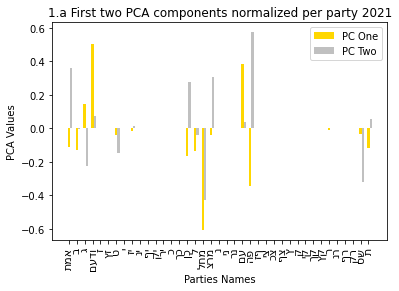

In [ ]:
pca = PCA(n_components=2)

merged_data_normalized = normalize(merged_data[df_2021.columns].T , axis=0)

res = pca.fit_transform(merged_data_normalized.T)  # Perform PCA transformation

pca_components = pd.DataFrame(pca.components_).T
pca_components = pca_components.div((pca_components**2).sum()**(1/2))

rev_names = [name[::-1] for name in df_2021.columns]
n = len(rev_names)  # number of parties


ax = plt.subplot()
width = 0.3  # set column width 
ax.bar(np.arange(n), pca_components[0], width, color='gold')
ax.bar(np.arange(n) + width, pca_components[1], width, color='silver')
plt.xticks(np.arange(n))
ax.set_ylabel('PCA Values')
ax.set_xlabel('Parties Names')
ax.set_title('1.a First two PCA components normalized per party 2021')
ax.set_xticks(np.arange(n))
ax.set_xticklabels(rev_names, rotation = 90, size =11)
ax.legend(['PC One', 'PC Two'])
plt.show()

From the graphs we can see that the biggest parties, which got throught the blocking percentage have received the biggest values for both PCA components. We also can see that the first component was mainly influences by biggest parties: "Mahal" and "Po".



**Question 1-b.i.**

Text(0.5, 1.0, '1.b.i Explained Variance by PCA Components')

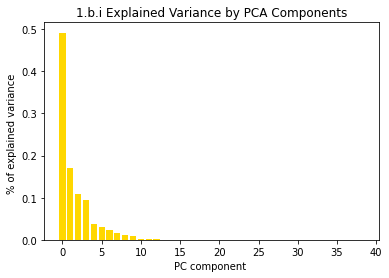

In [ ]:
pca = PCA() # for all the components.
res = pca.fit_transform(df_2021_ballots.T)
plt.bar(np.arange(39), pca.explained_variance_/pca.explained_variance_.sum(), color = "gold")
plt.ylabel('% of explained variance ')
plt.xlabel('PC component ')
plt.title("1.b.i Explained Variance by PCA Components")

According to the diagram of explained variance by PCA components, we would  lower the data according to this graph to dimension 3, as it can be seen that there is a trend in relative variability whereby there is a drastic decrease in variance explained by the following component. 
This means that each of the first three components does explain a large part of the model and therefore the difference between it and the next component is accompanied by this drastic decrease. So, the first component explains about 40 % of the model and the second component explains about 25 %. Starting from the fourth component and up the percentage of variance explained by each additional component is less than 5 %. The change that the addition of the 13th component contributes to the relative explained variance is 0.

**Question 1-b.ii.**

Text(0.5, 1.0, '1.b.ii Explained Variance by PCA Components')

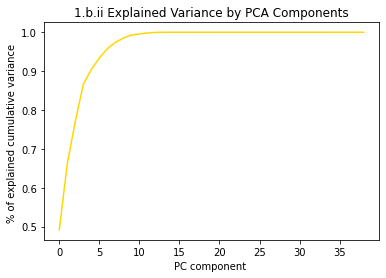

In [ ]:
plt.plot(np.arange(39), np.cumsum(pca.explained_variance_)/pca.explained_variance_.sum(), color = "gold")
plt.ylabel('% of explained cumulative variance ')
plt.xlabel('PCA component ')
plt.title("1.b.ii Explained Variance by PCA Components")

By running PCA and plotting the cumulative variance against the number of components explained, we can see that approximately 10 components explained about 98% of the total variance of our data.  So, we will reduce the size of our data to approximately 10-component feature set.

***Question 2.***

In [ ]:
df_2020 = pd.read_csv(io.BytesIO(uploaded['votes per city 2020.csv']),  encoding = 'iso-8859-8',index_col='שם ישוב') # loading data of 2020
df_2020 = df_2020[df_2020.columns[6:-1]] # removing "metadata" columns

# Matching of the parties in the 2020 elections to the 2021 elections:
df_2020['מרצ'] = round(df_2020['אמת']/2)
df_2020['אמת'] = round(df_2020['אמת']/2)
df_2020['עם'] = round(df_2020['ודעם']*0.4)
df_2020['ודעם'] = round(df_2020['ודעם']*0.6)
df_2020['ת'] = round(df_2020['מחל']*0.167)
df_2020['מחל'] = round(df_2020['מחל']*0.833)
df_2020['כן'] = round(df_2020['פה']*0.333)
df_2020['פה'] = round(df_2020['פה']*0.667)
df_2020['ב'] = round(df_2020['טב']*0.6)
df_2020['ט'] = round(df_2020['טב']*0.4 + df_2020['נץ'])

df_2021 = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8',index_col='שם ישוב') # loading data of 2021
df_2021 = df_2021[df_2021.index != 'מעטפות חיצוניות'] # dropping out מעטפות חיצוניות
df_2021 = df_2021[df_2021.columns[6:-1]] # removing "metadata" columns

total_votes_2021 = parties_votes_percents(df_2021, 0.035)  # Total voting for parties that passed the blocking percentage
names_2021 = total_votes_2021.keys() 
df_2021 = df_2021[names_2021]

df_2020 = df_2020[names_2021].astype(int) #Keeping the parties that passed the blocking percentage in the 2021 elections

df_2021.rename(columns=parties_dict_2021, inplace=True)
df_2020.rename(columns=parties_dict_2021, inplace=True)

In [ ]:
a = df_2020[~df_2020.index.isin(df_2021.index)] # wacth row added in 2021
b = df_2021[~df_2021.index.isin(df_2020.index)]
df_2021_clean = df_2021.drop(index=list(b.index)) # new row added in 2021
df_2020_clean = df_2020.drop(index=list(a.index)) # new row added in 2020


In [ ]:
merged_elec = pd.concat([df_2021_clean, df_2020_clean], axis=0, join="inner")
merged_not_normal = merged_elec
merged_elec = merged_elec.div(merged_elec.sum(axis=1), axis= 0) # normolaize

In [ ]:
size_by_cities = merged_not_normal.sum(axis=1)
size = 200*size_by_cities/ max(size_by_cities)
year = [2021] * 1211 + [2020] * 1211

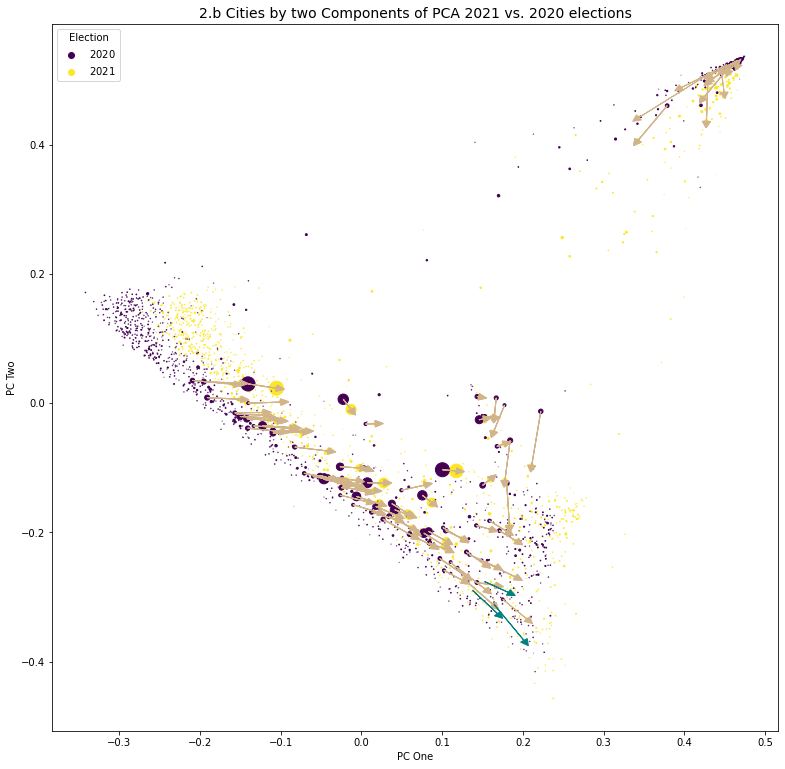

In [ ]:
# Show PCA plot for cities in 2021 and 2020
pca = PCA(n_components =2)
res = pca.fit_transform(merged_elec)  # Perform PCA transformation
fig, ax = plt.subplots(figsize=(13,13))
a = res[:,0]
b = res[:,1]
scatter = ax.scatter(a, b, s = size, c = year) # list(c.values()))
ax.set_title('2.b Cities by two Components of PCA 2021 vs. 2020 elections', fontsize=14)
ax.set_xlabel('PC One')
ax.set_ylabel('PC Two')
legend = ax.legend(*scatter.legend_elements(), title="Election")

cities_bid_from_10000 = size_by_cities[size_by_cities >= 10000]
for city in cities_bid_from_10000.index:
  dist = res[merged_elec.index.get_loc(city)]
  x_distance = dist[0][0] - dist[1][0]
  y_distance = dist[0][1] - dist[1][1]
  plt.arrow(dist[1][0], dist[1][1], x_distance, y_distance, width = 0.00001, head_width=0.01, head_length=0.01, color = "tan")

big_3_cities = merged_elec.index[pd.Series(((res[0:1211] - res[1211:2422])**2).sum(axis = 1)).nlargest(3).keys()]
for city in list(big_3_cities):
  dist = res[merged_elec.index.get_loc(city)]
  x_distance = dist[0][0] - dist[1][0]
  y_distance = dist[0][1] - dist[1][1]
  plt.arrow(dist[1][0], dist[1][1], x_distance, y_distance, width = 0.00001, head_width=0.01, head_length=0.01, color = "teal")

plt.show()

First of all, from analysing the plot, we can see that the population of the cities in 2021 did not changed drammaticly comparing to 2020. However, we can cleary see that votes distibution in a lot of cities has changed (the length of arrows). This does make sense, since in 2021 there were more parties, so people had more options to chose from, so thats's why the votes distribution for parties among citizens of one city has changed. The 3 cities that have changed their voting preferences in a most dramatic way are shown with green arrows.

In [ ]:
first = merged_elec[0:1211] 
second = merged_elec[1211:2422] 

def city_dif(city_name):
  n =13
  width = 0.3  
  a = "בחירות 1202"
  b = "בחירות 0202"
  names = parties_votes_percents(first, 0).keys()
  rev_names = [name[::-1] for name in list(names)]
  fig, ax = plt.subplots()  # plt.subplots()
  plt.xticks(rotation=35, ha='right')
  elec_1 = ax.bar(np.arange(n), list(first.loc[city_name]), width, color='g')
  elec_2 = ax.bar(np.arange(n)+width, list(second.loc[city_name]), width, color='b')
  ax.set_ylabel('Votes percent')
  ax.set_xlabel('Parties Names')
  ax.set_title(city_name[::-1])
  ax.set_xticks(np.arange(n))
  ax.set_xticklabels(rev_names)
  ax.legend((city_1_bar[0] , city_2_bar[0]), (a[::-1], b[::-1]))
  plt.show()

  return fig, ax  


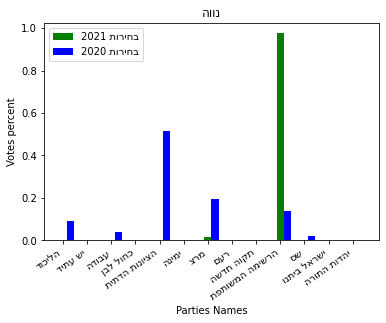

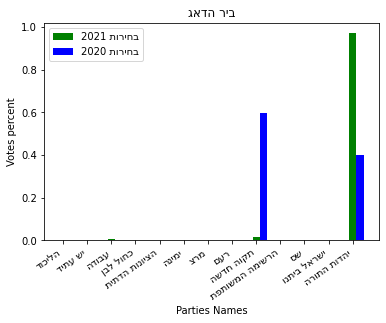

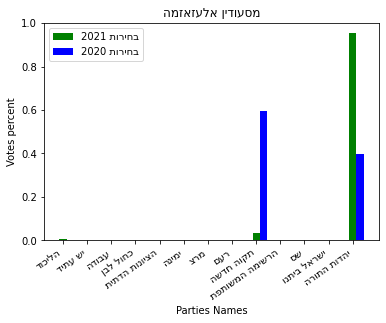

In [ ]:
largest_dif = ((first - second)**2).sum(axis=1).nlargest(3).index
for i in largest_dif:
  city_dif(i)

The 3 plots above reperesent the voting tendency in cities, where was the most dramatic change of voting pereferencies in 2021 comaring to 2020. 

*נווה*: We can see that in 2020, the votes had a broad distribution, however in 2021 the biggest part of the votes was given to "הרשימה המשותפת".

*ביר הדאג and מסעודין אלעזאזמה*: in 2020 we can see that the voters splitted between "יהדות התורה" and "תקוה חדשה", but in 2021 "יהדות התורה" had the biggest amoung of votes.

